## Preprocesamiento Proyecto Oil & Gas 

Importaciones y Configuraciones

Importamos las librerías esenciales. Basado en el EDA, necesitaremos manejar transformaciones (logs para sesgos), pipelines para reproducibilidad, y herramientas de visualización para validar.

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import sys
import os

sys.path.append(os.path.abspath(".."))
from utils.plot_tools import auditoria_de_datos


import warnings
warnings.filterwarnings("ignore")

Features Engineering: Generando Variables Físicas y Target

Al igual que en el EDA, identificamos que variables como la tasa de corrosión y porcentaje de pérdida son predictivas del mantenimiento. Aquí creamos features derivadas (Remaining_Percent, Corrosion_Rate_mm_y, Loss_Pct) usando fórmulas físicas reales de oil & gas. También generamos el target Maintenance_Required con umbrales conservadores. Esta función es reusable para la API.

In [2]:
def crear_features_fisicos(df_input):
    """
    Recibe el DataFrame crudo y devuelve el DF con las variables físicas calculadas.
    Esta función se usará acá y LUEGO en la API.
    """
    df = df_input.copy()
    
    # 1. Thickness_Loss_mm (Cap a Thickness_mm para que no sea mayor al espesor)
    # Si 'Thickness_Loss_mm' no viene en el original, asumimos que se calcula o viene cruda.
    # Si en tu RAW data viene 'Thickness_Loss_mm', aplicamos el clip.
    if 'Thickness_Loss_mm' in df.columns:
        df['Thickness_Loss_mm'] = df['Thickness_Loss_mm'].clip(upper=df['Thickness_mm'])
    
    # 2. Remaining_Percent
    # Evitamos división por cero con replace(0, np.nan)
    df['Remaining_Percent'] = 100 * (df['Thickness_mm'] - df['Thickness_Loss_mm']) / df['Thickness_mm'].replace(0, np.nan)
    
    # 3. Corrosion_Rate_mm_y
    # Evitamos división por cero en Time_Years
    df['Corrosion_Rate_mm_y'] = df['Thickness_Loss_mm'] / df['Time_Years'].replace(0, 1)
    
    # 4. Loss_Pct
    df['Loss_Pct'] = 100 * df['Thickness_Loss_mm'] / df['Thickness_mm'].replace(0, np.nan)
    
    #----- TARGET: Maintenance_Required -----
    # Creacion de Target Maintenance_Required
    df['Maintenance_Required'] = 0

    # 1. Condición operativa crítica
    crit1 = (df['Condition'] == 'Critical')

    # 2. Pérdida severa de espesor (conservador ~30-50%, cerca de API/B31G)
    crit2 = (df['Loss_Pct'] > 40) | (df['Remaining_Percent'] < 60)

    # 3. Tasa de corrosión alta
    crit3 = df['Corrosion_Rate_mm_y'] > 0.5

    # 4. Temperatura alta + corrosión
    crit4 = (df['Temperature_C'] > 80) & ((df['Corrosion_Impact_Percent'] > 12) | (df['Loss_Pct'] > 20))

    # 5. Pérdida material alta o impacto
    crit5 = (df['Material_Loss_Percent'] > 50) | (df['Corrosion_Impact_Percent'] > 20)

    # 6. Tiempo largo + degradación moderada (predicción futura)
    crit6 = (df['Time_Years'] > 15) & ((df['Loss_Pct'] > 25) | (df['Condition'] == 'Moderate'))

    # 7. Material sensible + pérdida moderada (Carbon Steel más crítico)
    crit7 = df['Material'].isin(['Carbon Steel']) & (df['Loss_Pct'] > 30)

    # 8. Presión alta + degradación (proxy)
    crit8 = (df['Max_Pressure_psi'] > 1200) & ((df['Loss_Pct'] > 20) | (df['Corrosion_Rate_mm_y'] > 0.3))

    df['Maintenance_Required'] = np.where(crit1 | crit2 | crit3 | crit4 | crit5 | crit6 | crit7 | crit8, 1, 0)
    df['Maintenance_Required'] = df['Maintenance_Required'].astype(bool)
        
    # Llenamos posibles NaNs generados por divisiones (opcional, o dejar que el imputer lo haga)
    df.fillna(0, inplace=True)
    
    return df

In [3]:
conn = sqlite3.connect("../data/industria.db")
cursor = conn.cursor()

# Le pedimos a la base de datos que nos liste todas sus tablas
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tablas = cursor.fetchall()

print("Tablas encontradas en la DB:", tablas)
conn.close()

Tablas encontradas en la DB: [('pipelines',), ('pipelines_transformed',)]


Carga de Datos desde SQL

Cargamos los datos desde la tabla 'pipelines' en la DB

In [4]:
#Carga de datos
print("Conectando a 'industria.db' y extrayendo features seleccionadas...")
conn = sqlite3.connect("../data/industria.db")

#Query: Se trae las columnas necesarias para el modelo

query = """
SELECT *
FROM pipelines
"""
df_raw = pd.read_sql(query, conn)
conn.close()

print("Datos cargados correctamente.")
print(f"Columnas: {list(df_raw.columns)}")

Conectando a 'industria.db' y extrayendo features seleccionadas...
Datos cargados correctamente.
Columnas: ['Pipe_Size_mm', 'Thickness_mm', 'Material', 'Grade', 'Max_Pressure_psi', 'Temperature_C', 'Corrosion_Impact_Percent', 'Thickness_Loss_mm', 'Material_Loss_Percent', 'Time_Years', 'Condition']


In [5]:
# Feature Engineering
print("Creando variables faltantes...")
df = crear_features_fisicos(df_raw)

print("Variables calculadas:")
display(df.head())

Creando variables faltantes...
Variables calculadas:


,Pipe_Size_mm,Thickness_mm,Material,Grade,Max_Pressure_psi,Temperature_C,Corrosion_Impact_Percent,Thickness_Loss_mm,Material_Loss_Percent,Time_Years,Condition,Remaining_Percent,Corrosion_Rate_mm_y,Loss_Pct,Maintenance_Required
0,800,15.48,Carbon Steel,ASTM A333 Grade 6,300,84.9,16.04,4.91,31.72,2,Moderate,68.281654,2.455000,31.718346,True
1,800,22.00,PVC,ASTM A106 Grade B,150,14.1,7.38,7.32,33.27,4,Critical,66.727273,1.830000,33.272727,True
2,400,12.05,Carbon Steel,API 5L X52,2500,0.6,2.12,6.32,52.45,7,Critical,47.551867,0.902857,52.448133,True
3,1500,38.72,Carbon Steel,API 5L X42,1500,52.7,5.58,6.20,16.01,19,Critical,83.987603,0.326316,16.012397,True
4,1500,24.32,HDPE,API 5L X65,1500,11.7,12.29,8.58,35.28,20,Critical,64.720395,0.429000,35.279605,True


In [6]:
# Division de datos en X e y (Target)
X = df.drop(columns=['Maintenance_Required'])
y = df['Maintenance_Required']

print("Datos divididos correctamente.")
print(f"X: {X.shape} \n{list(X.columns)}")
print(f"y: {y.shape} \n{list(y)}")

Datos divididos correctamente.
X: (1000, 14) 
['Pipe_Size_mm', 'Thickness_mm', 'Material', 'Grade', 'Max_Pressure_psi', 'Temperature_C', 'Corrosion_Impact_Percent', 'Thickness_Loss_mm', 'Material_Loss_Percent', 'Time_Years', 'Condition', 'Remaining_Percent', 'Corrosion_Rate_mm_y', 'Loss_Pct']
y: (1000,) 
[True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, False, False, True, True, True, True, False, True, True, False, True, True, True, True, True, False, True, True, True, True, True, False, True, True, False, True, False, False, False, True, True, True, True, True, True, True, False, False, False, False, True, True, True, True, True, False, True, False, False, True, True, False, True, True, False, True, True, True, True, True, True, False, False, True, True, True, True, False, False, True, True, True, True, False, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, 

In [7]:
# Definicion de Pipeline (Sklearn) para las transformaciones

print("Construyendo el Pipeline de Transformación...")

# Definicion de Columnas y sus trasformacions/tratamientos

# 1. Logaritmo + Scaling
cols_log = ['Pipe_Size_mm', 'Max_Pressure_psi']

# 2. Originales Numéricas (Solo Scaling)
cols_std = ['Temperature_C', 'Corrosion_Impact_Percent', 'Thickness_Loss_mm', 'Time_Years']

# 3. Categóricas (Ordinal y One-Hot)
cols_ord = ['Condition'] 
cols_nom = ['Material', 'Grade']

# 4. Logaritmos mas Winsorization
col_wins_log = ['Corrosion_Rate_mm_y']

# Pipelines
log_pipeline = Pipeline([
    ('log', FunctionTransformer(np.log1p, validate=False)),
    ('scaler', StandardScaler())
])

ordinal_pipeline = Pipeline([
    ('ordinal', OrdinalEncoder(categories=[['Normal', 'Moderate', 'Critical']],
                               handle_unknown='use_encoded_value', 
                               unknown_value=-1))
])

onehot_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

wins_log_pipeline = Pipeline([
    ('log', FunctionTransformer(np.log1p, validate=False)), 
    ('scaler', RobustScaler())
])

Construyendo el Pipeline de Transformación...


In [8]:
# Preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('tr_log_std', log_pipeline, cols_log),
        ('tr_std', StandardScaler(), cols_std),
        ('tr_ord', ordinal_pipeline, cols_ord),
        ('tr_onehot', onehot_pipeline, cols_nom),
        ('tr_wins_log', wins_log_pipeline, col_wins_log)
    ], 
    remainder='drop'
)

In [9]:
# Split Train/Test
print("Dividiendo Train/Test...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Entrenando el Preprocesador...")
# Fit en Train
preprocessor.fit(X_train)

#Trasformamos para entrenar rapido despues
X_train_prepro = preprocessor.transform(X_train)
X_test_prepro = preprocessor.transform(X_test)

Dividiendo Train/Test...
Entrenando el Preprocesador...


In [10]:
# Intentamos recuperar nombres de columnas para guardar lindo
try:
    # Esta parte es truco avanzado para sacar nombres de OneHot y demás
    def get_names(transformer):
        names = []
        names.extend([c + "_log" for c in cols_log])
        names.extend([c + "_wins_log" for c in col_wins_log])
        names.extend(cols_std)
        names.extend(cols_ord)
        names.extend(transformer.named_transformers_['tr_onehot']['onehot'].get_feature_names_out(cols_nom))
        return names
    
    feature_names = get_names(preprocessor)
    X_train_df = pd.DataFrame(X_train_prepro, columns=feature_names)
    X_test_df = pd.DataFrame(X_test_prepro, columns=feature_names)
except:
    X_train_df = pd.DataFrame(X_train_prepro)
    X_test_df = pd.DataFrame(X_test_prepro)


display(X_train_df.head())
display(X_test_df.head())


,Pipe_Size_mm_log,Max_Pressure_psi_log,Corrosion_Rate_mm_y_wins_log,Temperature_C,Corrosion_Impact_Percent,Thickness_Loss_mm,Time_Years,Condition,Material_Fiberglass,Material_HDPE,Material_PVC,Material_Stainless Steel,Grade_API 5L X52,Grade_API 5L X65,Grade_ASTM A106 Grade B,Grade_ASTM A333 Grade 6
0,-0.108468,-0.842850,-1.647935,1.354681,-1.315651,-0.157929,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.590773
1,0.861528,-1.571852,-0.170963,-0.814677,-0.466180,-0.856730,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.253420
2,-0.288500,1.394719,-0.846496,-1.311071,1.060622,0.401112,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.229667
3,-0.792128,-1.571852,0.937977,-0.763149,1.270183,0.960153,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.104424
4,0.396471,-0.842850,0.991245,-0.586234,1.921319,0.960153,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.271744


,Pipe_Size_mm_log,Max_Pressure_psi_log,Corrosion_Rate_mm_y_wins_log,Temperature_C,Corrosion_Impact_Percent,Thickness_Loss_mm,Time_Years,Condition,Material_Fiberglass,Material_HDPE,Material_PVC,Material_Stainless Steel,Grade_API 5L X52,Grade_API 5L X65,Grade_ASTM A106 Grade B,Grade_ASTM A333 Grade 6
0,-1.867874,-1.571852,0.124432,1.449150,-1.618766,-0.157929,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.768288
1,1.483937,0.855168,0.117168,0.032111,0.439423,-0.018169,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.189938
2,1.262954,-1.571852,0.214019,0.605797,1.419870,-1.276011,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.304577
3,-0.792128,-0.112099,-1.030512,1.145131,0.809897,1.239673,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.084526
4,-0.508662,1.394719,0.286657,-0.517529,-0.600898,-1.415771,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.082359


In [11]:
# Guardado de archivos 
print("\nGuardando Todo...")
X_train_df.to_csv("../data/X_train_processed.csv", index=False)
X_test_df.to_csv("../data/X_test_processed.csv", index=False)
y_train.to_csv("../data/y_train.csv", index=False)
y_test.to_csv("../data/y_test.csv", index=False)

# Guardamos el Preprocesador (Clave para la API)
joblib.dump(preprocessor, '../models/preprocessor.pkl')
joblib.dump(list(X_train_df.columns), '../models/model_columns.pkl') # Guardamos nombres de columnas por las dudas

print("Variables creadas, transformadas y guardadas.")


Guardando Todo...
Variables creadas, transformadas y guardadas.


Verificacion Post-Preprocesamiento 

Finalmente, auditamos el set de test transformado para confirmar que el pipeline funcionó bien. Deberíamos ver mejoras en skew/kurtosis para features como Corrosion_Rate. Esto asegura que los datos estén listos para entrenamiento y dashboards en Streamlit.


Generando Gráficos de Control de Calidad...


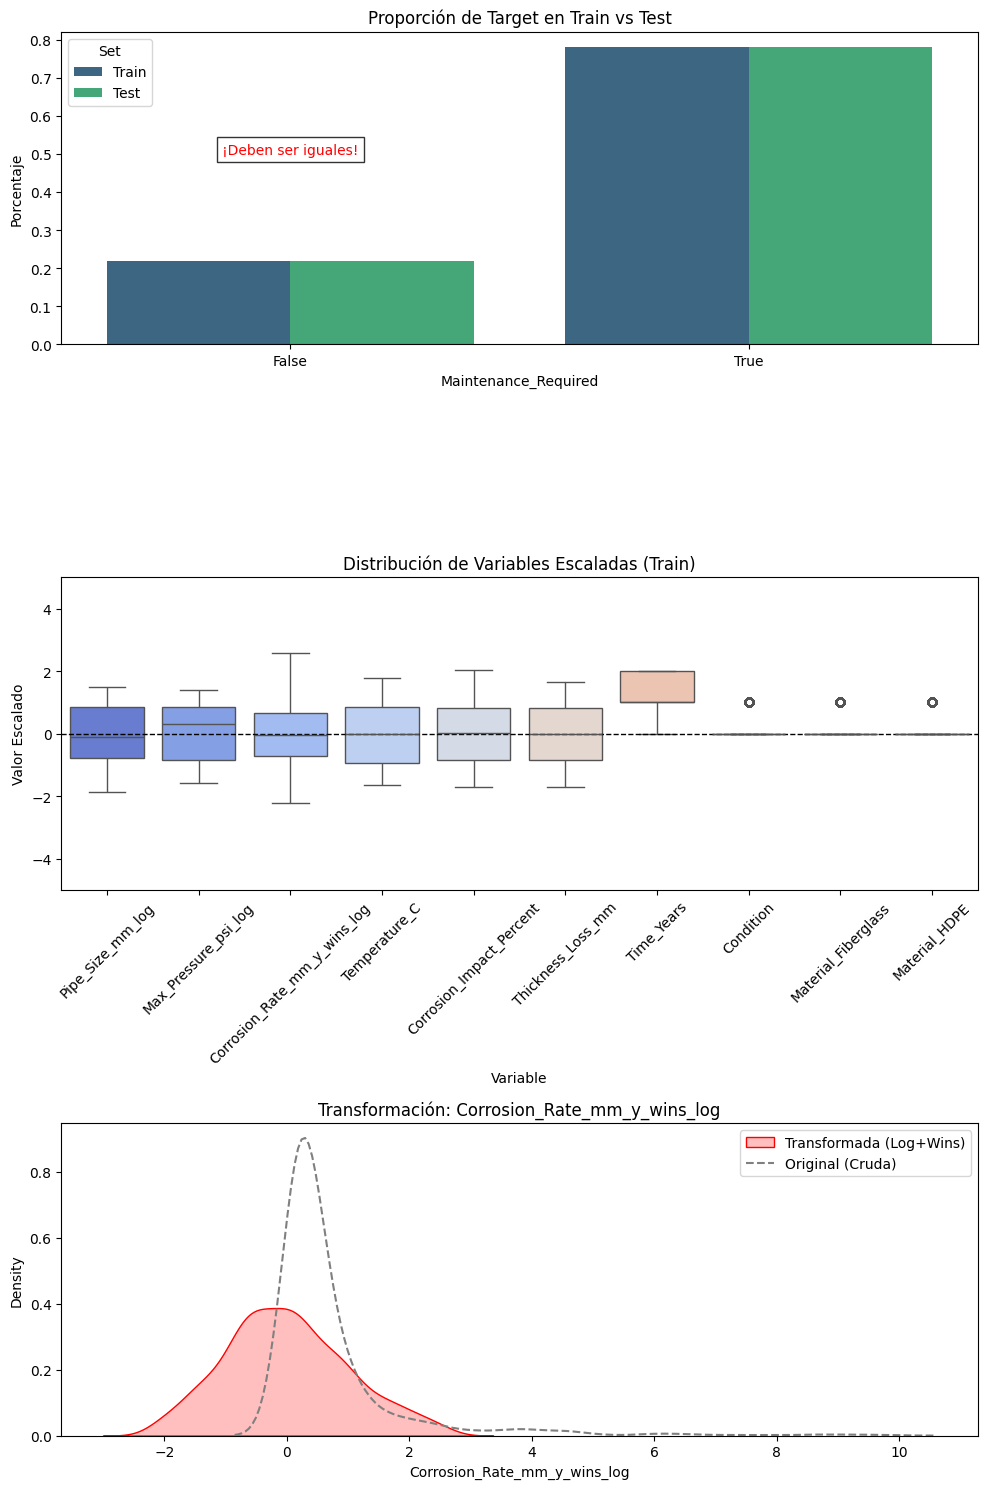

Interpretación:
1. Barras iguales: El split estratificado funcionó.
2. Cajas alineadas en 0: El StandardScaler funcionó.
3. Curva Roja más 'normal' que la Gris: El Logaritmo funcionó.


In [12]:
print("\nGenerando Gráficos de Control de Calidad...")

fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# --- GRÁFICO 1: Verificación del Split (Stratify) ---
df_train_dist = y_train.value_counts(normalize=True).reset_index()
df_train_dist['Set'] = 'Train'
df_test_dist = y_test.value_counts(normalize=True).reset_index()
df_test_dist['Set'] = 'Test'
df_dist = pd.concat([df_train_dist, df_test_dist])

sns.barplot(data=df_dist, x='Maintenance_Required', y='proportion', hue='Set', ax=axes[0], palette='viridis')
axes[0].set_title("Proporción de Target en Train vs Test")
axes[0].set_ylabel("Porcentaje")
axes[0].text(0, 0.5, "¡Deben ser iguales!", ha='center', color='red', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

# --- GRÁFICO 2: Verificación del Escalado (Boxplot) ---
cols_to_plot = X_train_df.columns[:10]
X_melted = X_train_df[cols_to_plot].melt(var_name='Variable', value_name='Valor Escalado')

sns.boxplot(data=X_melted, x='Variable', y='Valor Escalado', ax=axes[1], palette='coolwarm')
axes[1].set_title("Distribución de Variables Escaladas (Train)")
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_ylim(-5, 5)
axes[1].axhline(0, color='black', linestyle='--', linewidth=1)


# --- GRÁFICO 3: Efecto de la Transformación (Corrosion Rate) ---
col_transf = "Corrosion_Rate_mm_y_wins_log"

sns.kdeplot(X_train_df[col_transf], ax=axes[2], color='red', label='Transformada (Log+Wins)', fill=True)

# Curva original (dataset crudo)
sns.kdeplot(df['Corrosion_Rate_mm_y'], ax=axes[2], color='grey', linestyle='--', label='Original (Cruda)')

axes[2].set_title(f"Transformación: {col_transf}")
axes[2].legend()

plt.tight_layout()
plt.show()

print("Interpretación:")
print("1. Barras iguales: El split estratificado funcionó.")
print("2. Cajas alineadas en 0: El StandardScaler funcionó.")
print("3. Curva Roja más 'normal' que la Gris: El Logaritmo funcionó.")

In [13]:
#Metricas finales de control de calidad
print('Metricas de X_train_df')
reporte_X_train = auditoria_de_datos(X_train_df)
reporte_X_train



Metricas de X_train_df
Informacion del Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Pipe_Size_mm_log              800 non-null    float64
 1   Max_Pressure_psi_log          800 non-null    float64
 2   Corrosion_Rate_mm_y_wins_log  800 non-null    float64
 3   Temperature_C                 800 non-null    float64
 4   Corrosion_Impact_Percent      800 non-null    float64
 5   Thickness_Loss_mm             800 non-null    float64
 6   Time_Years                    800 non-null    float64
 7   Condition                     800 non-null    float64
 8   Material_Fiberglass           800 non-null    float64
 9   Material_HDPE                 800 non-null    float64
 10  Material_PVC                  800 non-null    float64
 11  Material_Stainless Steel      800 non-null    float64
 12  Grade_API 5L X52

,mean,median,std,min,max,cv,skew,kurtosis,outliers,variance
Pipe_Size_mm_log,-1.029177e-15,-1.084680e-01,1.000626,-1.867874,1.483937,1.000626e+06,-0.292890,-0.903612,0.000,1.001252
Max_Pressure_psi_log,-1.632028e-16,3.158042e-01,1.000626,-1.571852,1.394719,1.000626e+06,-0.203748,-1.151818,0.000,1.001252
Corrosion_Rate_mm_y_wins_log,1.110223e-16,-4.505674e-02,1.000626,-2.214511,2.582017,1.000626e+06,0.277214,-0.302507,0.000,1.001252
Temperature_C,-2.531308e-16,-1.382687e-03,1.000626,-1.649443,1.785805,1.000626e+06,0.087406,-1.232462,0.000,1.001252
Corrosion_Impact_Percent,-6.883383e-17,2.404339e-02,1.000626,-1.708577,2.026100,1.000626e+06,0.059040,-1.046313,0.000,1.001252
Thickness_Loss_mm,-1.199041e-16,-1.816883e-02,1.000626,-1.695292,1.658954,1.000626e+06,-0.055080,-1.199700,0.000,1.001252
Time_Years,1.265000e+00,1.000000e+00,0.792502,0.000000,2.000000,6.264346e+01,-0.508785,-1.232107,0.000,0.628060
Condition,2.200000e-01,0.000000e+00,0.414505,0.000000,1.000000,1.883260e+02,1.354394,-0.166039,22.000,0.171815
Material_Fiberglass,1.800000e-01,0.000000e+00,0.384428,0.000000,1.000000,2.134524e+02,1.668984,0.787471,18.000,0.147785
Material_HDPE,1.700000e-01,0.000000e+00,0.375868,0.000000,1.000000,2.209687e+02,1.760337,1.101535,17.000,0.141277


In [14]:
print('Metricas de X_test_df')
reporte_X_test = auditoria_de_datos(X_test_df)
reporte_X_test

Metricas de X_test_df
Informacion del Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Pipe_Size_mm_log              200 non-null    float64
 1   Max_Pressure_psi_log          200 non-null    float64
 2   Corrosion_Rate_mm_y_wins_log  200 non-null    float64
 3   Temperature_C                 200 non-null    float64
 4   Corrosion_Impact_Percent      200 non-null    float64
 5   Thickness_Loss_mm             200 non-null    float64
 6   Time_Years                    200 non-null    float64
 7   Condition                     200 non-null    float64
 8   Material_Fiberglass           200 non-null    float64
 9   Material_HDPE                 200 non-null    float64
 10  Material_PVC                  200 non-null    float64
 11  Material_Stainless Steel      200 non-null    float64
 12  Grade_API 5L X52 

,mean,median,std,min,max,cv,skew,kurtosis,outliers,variance
Pipe_Size_mm_log,0.073199,0.175817,0.957303,-1.867874,1.483937,1306.027981,-0.262613,-0.809025,0.0,0.916430
Max_Pressure_psi_log,0.087473,0.315804,1.012660,-1.571852,1.394719,1156.365053,-0.299448,-1.138212,0.0,1.025481
Corrosion_Rate_mm_y_wins_log,-0.056328,-0.049899,0.977408,-2.253251,2.482745,1732.141816,0.229228,-0.056546,0.0,0.955327
Temperature_C,0.122759,0.135168,0.990008,-1.630549,1.758323,805.811490,-0.077212,-1.191073,0.0,0.980117
Corrosion_Impact_Percent,0.079802,0.057723,1.089108,-1.704835,2.022358,1363.061775,0.117882,-1.108072,0.0,1.186157
Thickness_Loss_mm,-0.118097,-0.088049,0.980815,-1.695292,1.658954,829.810512,0.104692,-1.076451,0.0,0.961997
Time_Years,1.305000,2.000000,0.790633,0.000000,2.000000,60.580260,-0.600776,-1.147768,0.0,0.625101
Condition,0.215000,0.000000,0.411853,0.000000,1.000000,191.470604,1.397968,-0.046249,21.5,0.169623
Material_Fiberglass,0.200000,0.000000,0.401004,0.000000,1.000000,200.401682,1.511359,0.286975,20.0,0.160804
Material_HDPE,0.250000,0.000000,0.434099,0.000000,1.000000,173.570296,1.163445,-0.653028,25.0,0.188442


In [15]:
print('Division del target con Stratify')
print('\ny_test value')
check_y_test = y_test.value_counts()
print(check_y_test)
#porcentaje de cada valor
print('y_test %')
check_y_test_percentage = y_test.value_counts(normalize=True)
print(f'{check_y_test_percentage * 100}')

print('\ny_train value')
check_y_train = y_train.value_counts()
print(check_y_train)
#porcentaje de cada valor
print('y_train %')
check_y_train_percentage = y_train.value_counts(normalize=True)
print(f'{check_y_train_percentage * 100}')

Division del target con Stratify

y_test value
Maintenance_Required
True     156
False     44
Name: count, dtype: int64
y_test %
Maintenance_Required
True     78.0
False    22.0
Name: proportion, dtype: float64

y_train value
Maintenance_Required
True     625
False    175
Name: count, dtype: int64
y_train %
Maintenance_Required
True     78.125
False    21.875
Name: proportion, dtype: float64


### Conclusiones Finales del Preprocesamiento

Se transformaron los datos del EDA en un dataset listo para modelado: features físicas enriquecidas, target generado con criterios API, y pipeline con transforms (logs, winsorizing, scalers) y encoders.

Validación: Split equilibrado (~78% True en target), distribuciones normalizadas (skew/kurtosis mejorados, e.g., Corrosion_Rate simétrica), sin nulos/duplicados/outliers inesperados. Train (800x16) y test (200) estables.
Insights: Mejora en calidad de datos para algoritmos; listo para FastAPI/Streamlit